In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
from utilities.pythonDB import writeToDB, deleteExistingPrimaryKeyDB
from utilities.resnet import ResNet18, ResNet34
%matplotlib inline

In [2]:
def get_random_data(data1, data2, low, high, max_samples=100):
    _, H1, W1, C1 = data1.shape
    _, N = data2.shape
    suff_data1 = np.zeros((max_samples, H1, W1, C1))
    suff_data2 = np.zeros((max_samples, N))
    shuffles = np.random.randint(low, high+1, max_samples)
    for idx in range(shuffles.shape[0]):
        suff_data1[idx] = data1[idx, :, :, :]
        suff_data2[idx] = data2[idx, :]
    return suff_data1, suff_data2

In [3]:
MAX_TRAINING = 25000
MAX_VALIDATION = 5000
MAX_TESTING = 4000
correct_class = {0 : 'airplane', 1 : 'automobile', 2 : 'bird', 3 : 'cat', 4 : 'deer', \
                 5 : 'dog', 6 : 'frog', 7 : 'horse', 8 : 'ship', 9 : 'truck'}

In [4]:
cifar = tf.keras.datasets.cifar10
(x_train_o, y_train_o), (x_test_o, y_test_o) = cifar.load_data()

In [17]:
from utilities.data_preprocessors import flip_vertical_np, flip_horizontal_np, rotate_np, flip_rotate, \
perform_swirl_transformation, perform_random_affine_transform, mixed_transformations, add_gaussian_noise, add_sp_noise, \
add_poisson_noise, add_multiplicative_noise, random_image_eraser, correct_low_visibility, gamma_correction

class TransformDataset(object):
    def scale(self, X, x_min=0, x_max=1):
        nom = (X-X.min(axis=0))*(x_max-x_min)
        denom = X.max(axis=0) - X.min(axis=0)
        denom[denom==0] = 1
        return x_min + nom/denom
    def return_function(self, name, im):
        return getattr(self, 'if_' + name)(correct_low_visibility(im))
    def if_flip_vertical_np(self, im):
        return self.scale(flip_vertical_np(im))
    def if_flip_horizontal_np(self, im):
        return self.scale(flip_horizontal_np(im))
    def if_rotate_np(self, im):
        return self.scale(rotate_np(im))
    def if_flip_rotate(self, im):
        return self.scale(flip_rotate(im))
    def if_perform_swirl_transformation(self, im):
        return self.scale(perform_swirl_transformation(im))
    def if_perform_random_affine_transform(self, im):
        return self.scale(perform_random_affine_transform(im))
    def if_mixed_transformations(self, im):
        return self.scale(mixed_transformations(im))
    def if_add_gaussian_noise(self, im):
        return self.scale(add_gaussian_noise(im))
    def if_add_sp_noise(self, im):
        return self.scale(add_sp_noise(im))
    def if_add_poisson_noise(self, im):
        return self.scale(add_poisson_noise(im))
    def if_add_multiplicative_noise(self, im):
        return self.scale(add_multiplicative_noise(im))
    def if_random_image_eraser(self, im):
        return self.scale(random_image_eraser(im))
    def if_correct_low_visibility(self, im):
        return self.scale(correct_low_visibility(im))
    def if_gamma_correction(self, im):
        return self.scale(gamma_correction(im))

def get_random_shuffle_set(data1, data2, ratios=None, notFull=False):
    if ratios is None:
        ratios = {"flip_vertical_np":.1, 'flip_horizontal_np':.1, 'rotate_np':.15, 'flip_rotate':.2, \
                  'perform_swirl_transformation':.1, 'perform_random_affine_transform':.15, 'mixed_transformations':.2}
    _, H1, W1, C1 = data1.shape
    N, _ = data2.shape
    total = int(np.round(np.sum([ratios.get(k) for k in ratios.keys()]) * N, 1))
    new_N = total if total != N else N
    
    shuffles = np.random.randint(0, N, new_N)
    low = 0
    x_train_ret, y_train_ret, img_idx  = np.zeros((new_N, H1, W1, C1)), np.zeros((new_N, 1)), 0

    for key in ratios.keys():
        high = int(ratios.get(key) * N)
        data = shuffles[low:low+high]
        low += high
        for idxs in data:
            x_train_ret[img_idx] = TransformDataset().return_function(key, data1[idxs])
            y_train_ret[img_idx] = data2[idxs]
            img_idx += 1
    return x_train_ret, y_train_ret

In [ ]:
ratio1 = {"gamma_correction": 0.8, "correct_low_visibility":0.10, "random_image_eraser":.10}
total = int(np.round(np.sum([ratio1.get(k) for k in ratio1.keys()]) * N, 1))
total

In [27]:
ratio1 = {"gamma_correction": 0.01, "correct_low_visibility":0.01, "random_image_eraser":.01}
#ratio2 = {"add_gaussian_noise": 0.01, "add_sp_noise": 0.01, "add_poisson_noise":.01, 'add_multiplicative_noise':.01}

x_train_ret1, y_train_ret1 = get_random_shuffle_set(x_train_o, y_train_o, ratio1)

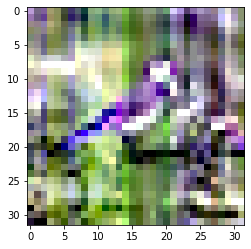

In [32]:
plt.imshow(x_train_ret1[13])